<img src='sharif_logo.png' alt="SUT logo" width=150 height=150 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Learning <br>
<font color=2565AE size=5>
Computer Engineering Department - Spring 2025  <br>
<font color=3C99D size=5>
          Homework 3: Practical - GPT2 from Scratch! <br>
<font color=696880 size=4>
            Designer: Shaygan Adim
    
    

**Name**: Nikan Vasei 
  
**Student Code**: 400105303

# Overview

In this project, you will implement a scaled-down version of OpenAI's GPT-2 architecture from scratch using PyTorch. You'll train this model on the Snappfood comments with sentiment labels. The goal is to create a generative language model that can produce synthetic Persian comments with controllable sentiment (positive or negative).

# Learning Objectives

* Understanding and implementing transformer-based language model architectures  
* Learning how to control text generation using special tokens  
* Visualizing and analyzing training progress  

# Dataset

You'll work with a Persian dataset containing Snappfood comments:  

* The dataset texts are normalized (No need for any normalizations)
* Each comment has a sentiment label (1 for positive, 0 for negative)
* The dataset contains text with variations in length and style

# Tokenizer and model

You should use one of the sota open-source LLM tokenizers. I strongly recommend using Llama 3.3 tokenizer or Gemma-2 tokenizer as they're better than the others in Persian language. (There is no need to implement a tokenizer yourself.)

Your model should have the exact srtructure of GPT-2:  
  
<img src="GPT-2.png" alt="" width="600" height="800">
  
For the model to be able to smoothly be trained, you should use the config below:

* **Embedding Dimension**: 192 (reduced from 768 in original GPT-2)
* **Layers**: 3 transformer blocks (reduced from 12 in original GPT-2)
* **Attention Heads**: 3 (reduced from 12 in original GPT-2)
* **Context Window**: 128 tokens (reduced from 1024 in original GPT-2)

Moreover, unlike the original Transformer paper that used fixed sinusoidal position encodings, GPT-2 (and your implementation) should use learnable position embeddings:
1. You should create an embedding table of size [n_positions, n_embd] where:

    * n_positions is the maximum sequence length (128 in our model)
    * n_embd is the embedding dimension (192 in our model)
2. For each position in the sequence (0 to sequence_length-1), we look up the corresponding embedding vector.

3. These position embeddings are added to the token embeddings before being passed through the transformer blocks.

# Some notes:

* Be aware that you will be questioned about your solution to this assignment in-person. Thus, build a solid understanding through out solving this assignment.
* Using ChatGPT and other LLMs are allowed but you should be able to explain every line of your code completely.
* You need GPU for this assignment. Use can use Colab or Kaggle for free.
* I highly recommend using the exact same structure and instructions that is provided for you in the notebook but minor changes will be tolerated.
* Read the whole notebook once before coding. It will give you a broad vision about what you should do on the whole.
* Instructions provided for you in TODO sections ARE NOT the only things that you should do in those parts. They're just some important bullet points that your code should have.
* The final results (Inference section) should have the minimum quality of the samples already generated in the notebook.

# Importing

In [1]:
# Data loading and manipulation
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Tokenization utilities
from transformers import AutoTokenizer
from huggingface_hub import login

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Visualization tool
import matplotlib.pyplot as plt

# Runtime utilities
import math
import time
from tqdm import tqdm

# Typing tool
from typing import Dict, Optional, Any

# Downloading and loading the data

In this section we read and load the data from [here](https://www.kaggle.com/datasets/mohammad1ziyar/cleaned-snappfood-persian-sentiment-analysis).

You can also see some information about the data in the next cell. In the end, we only want the label and cleaned columns.

In [2]:
# TODO: Download the dataset using kagglehub

path = '/kaggle/input/cleaned-snappfood-persian-sentiment-analysis/'

print("Path to dataset files:", path)

raw_corpus = pd.read_csv(path + "/cleaned_snappfood.csv")

Path to dataset files: /kaggle/input/cleaned-snappfood-persian-sentiment-analysis/


In [3]:
raw_corpus.info()
raw_corpus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65973 entries, 0 to 65972
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   comment          65973 non-null  object
 1   label            65973 non-null  int64 
 2   comment_length   65973 non-null  int64 
 3   comment_cleaned  65973 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.0+ MB


,comment,label,comment_length,comment_cleaned
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,0,47,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,1,132,قرار بود ساعته برسه ولی نیم ساعت زودتر از موق...
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,0,89,قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...
3,عالی بود همه چه درست و به اندازه و کیفیت خوب، ...,1,99,عالی بود همه چه درست و به اندازه و کیفیت خوب ا...
4,شیرینی وانیلی فقط یک مدل بود.,1,29,شیرینی وانیلی فقط یک مدل بود


In [4]:
raw_corpus = raw_corpus[["comment_cleaned", "label"]]

# Downloading and loading the tokenizer (5 Points)

In this section you need to load your tokenizer from hugging face. I recommend [this](https://huggingface.co/meta-llama/Llama-3.3-70B-Instruct) or [this](https://huggingface.co/google/gemma-2-27b-it).
Keep in mind that you might need to login first using your hugging face access token and also sign an agreement thing in model's page to be able to access the model and it's tokenizer.

In [ ]:
# TODO: Set up authentication (if needed) and initialize a tokenizer
#  Use the login() function to authenticate with your Hugging Face token (if needed)
#  Initialize a tokenizer using the AutoTokenizer class

login(token="TOKEN")

tokenizer = AutoTokenizer.from_pretrained(
    "google/gemma-2-27b-it",
    use_fast=True,
    trust_remote_code=True
)

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In the cell below, add two special tokens to the vocabulary of the tokenizer indicating positivity or negativity of a comment. We will add these tokens manually as the first token of each comment so model will understand the difference between positive and negative comments.

In [6]:
# TODO: Add custom special tokens to the tokenizer

# 1. Create a dictionary named 'special_tokens' with a key 'additional_special_tokens' that contains a list of two special tokens for positivity and negativity
# 2. Add these tokens to the vocabulary

# These special tokens will be used to tell the model what sentiment we're expecting during training and inference.

special_tokens = {
    "additional_special_tokens": ["<POS>", "<NEG>"]
}
tokenizer.add_special_tokens(special_tokens)

2

## Dataset and Dataloader (10 Points)

Create a custom Dataset class for the data

In [7]:
class CommentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.comments = dataframe['comment_cleaned'].tolist()
        self.labels = dataframe['label'].tolist()
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.comments)

    def __getitem__(self, idx: int) -> dict:
        # TODO: Process a single item from the dataset
        # This method should:
        # 1. Get the appropriate label and comment at the given index
        comment = self.comments[idx]
        label = self.labels[idx]
        # 2. Create a prefix based on the sentiment
        prefix = "<POS>" if label == 1 else "<NEG>"
        text = f"{prefix} {comment}"
        # 3. Tokenize the text
        encoded = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)
        labels = input_ids.clone()
        # Later in CrossEntropy we'll use ignore_index=-100 and thus will ignore these tokens (pad tokens)
        labels[attention_mask == 0] = -100
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

Create train and validation datasets and dataloaders and also split the data

In [8]:
# TODO: Prepare the training and validation datasets and dataloaders
#
# 1. Split the raw_corpus dataframe into training and validation sets with a suitable ratio
# 2. Create dataset instances using the CommentDataset class:
# 3. Create DataLoader instances

train_df, val_df = train_test_split(
    raw_corpus,
    test_size=0.2,
    random_state=42,
    stratify=raw_corpus['label']
)

train_dataset = CommentDataset(train_df, tokenizer, max_length=128)
val_dataset = CommentDataset(val_df, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## Model implementation (35 Points)

In this section you should implement the model architecture completely from scratch. No pre-defined torch or other libraries tools are allowed. (Even for the attention mechanism)

In [9]:
class GPT2Config:
    def __init__(
        self,
        vocab_size,
        n_positions,  
        n_embd,
        n_layer,
        n_head,
        n_inner=None,
        activation_function="gelu",
        resid_pdrop=0.1,
        embd_pdrop=0.1,
        attn_pdrop=0.1,
        layer_norm_epsilon=1e-5,
        initializer_range=0.02,
        bos_token_id=None,
        eos_token_id=None,
    ):
        self.vocab_size = vocab_size
        self.n_positions = n_positions
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_inner = 4 * n_embd if n_inner is None else n_inner
        self.activation_function = activation_function
        self.resid_pdrop = resid_pdrop
        self.embd_pdrop = embd_pdrop
        self.attn_pdrop = attn_pdrop
        self.layer_norm_epsilon = layer_norm_epsilon
        self.initializer_range = initializer_range
        self.bos_token_id = bos_token_id
        self.eos_token_id = eos_token_id

In [10]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.attn_pdrop

        # TODO: Initialize the query, key, value projection layer
        # Create a single linear layer (c_attn) that projects the input embeddings to query, key, and value vectors
        # The output dimension should be 3 * config.n_embd
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # TODO: Initialize the output projection layer
        # Create a linear layer (c_proj) that projects the attention output back to the embedding dimension
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

        # TODO: Create the causal attention mask
        # Register a buffer named "mask" with shape (config.n_positions, config.n_positions)
        self.register_buffer('mask', torch.tril(torch.ones(config.n_positions, config.n_positions)))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality

        # TODO: Implement the multi-head attention mechanism
        # 1. Project input x to query, key, and value using self.c_attn
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        # Then we should split them to match the multi-head architecture
        hs = C // self.n_head
        q = q.view(B, T, self.n_head, hs).transpose(1, 2)
        k = k.view(B, T, self.n_head, hs).transpose(1, 2)
        v = v.view(B, T, self.n_head, hs).transpose(1, 2)
        # 2. Compute attention scores:
        attn_scores = (q @ k.transpose(-2, -1)) / math.sqrt(hs)
        attn_scores = attn_scores.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        # 3. Apply attention weights to values
        y = attn_weights @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C) 
        # 4. Apply the output projection and residual dropout
        y = self.c_proj(y)
        y = self.resid_dropout(y)
        
        return y

In [11]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_inner)
        self.c_proj = nn.Linear(config.n_inner, config.n_embd)
        self.dropout = nn.Dropout(config.resid_pdrop)
        self.activation_function = config.activation_function
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Implement the feed-forward network forward pass
        x = self.c_fc(x)
        x = getattr(F, self.activation_function)(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        
        return x

In [12]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        # TODO: Initialize the components of a transformer block
        self.ln_1 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.mlp = MLP(config)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Implement the transformer block forward pass with residual connections
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        
        return x

In [13]:
class GPT2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict({
            'wte': nn.Embedding(config.vocab_size, config.n_embd),
            'wpe': nn.Embedding(config.n_positions, config.n_embd),
            'drop': nn.Dropout(config.embd_pdrop),
            'h': nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            'ln_f': nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        })

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer['wte'].weight = self.lm_head.weight 

        self.apply(self._init_weights)

    def _init_weights(self, module):
        # TODO: Implement the weight initialization function
        # 1. For Linear and Embedding layers:
        #    - Initialize weights from a normal distribution with mean=0.0 and 
        #      std=self.config.initializer_range
        #    - For Linear layers with bias, initialize the bias to zero
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        # 2. For LayerNorm layers:
        #    - Initialize bias to zero
        #    - Initialize weight to ones
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None, 
                labels: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        # TODO: Implement the forward pass
        bsz, seq_len = input_ids.size()
        device = input_ids.device
        # 1. Create position indices
        position_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(bsz, -1)
        # 2. Compute embeddings
        inputs_embeds = self.transformer['wte'](input_ids)
        pos_embeds = self.transformer['wpe'](position_ids)
        x = self.transformer['drop'](inputs_embeds + pos_embeds)
        # 3. Process the input through transformer blocks
        for block in self.transformer['h']:
            x = block(x)
        # 4. Apply final layer normalization
        x = self.transformer['ln_f'](x)
        # 5. Compute logits using the language model head
        logits = self.lm_head(x)
        # 6. Return a dictionary with 'logits' and 'loss' (if calculated)
        loss = None
        if labels is not None:
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            loss = nn.CrossEntropyLoss(ignore_index=-100)(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )
            
        return {'logits': logits, 'loss': loss}

    def generate(self, input_ids: torch.Tensor, max_length: int, 
                temperature: float = 1.0, top_k: int = 0, top_p: float = 0.9) -> torch.Tensor:
        # TODO: Implement text generation with various decoding strategies
        # This method should generate text auto-regressively using the trained model
        # with temperature, top-k, and nucleus (top-p) sampling techniques.
        #
        # 1. Set the model to evaluation mode
        self.eval()
        cur_ids = input_ids
        # 2. Loop to generate 'max_length' new tokens:
        for _ in range(max_length):
        #    a. Run the forward pass to get logits for the current sequence
            outputs = self.forward(cur_ids)
            logits = outputs['logits']
        #    b. Extract logits for the last token and apply temperature scaling
            next_token_logits = logits[:, -1, :] / temperature
        #    c. Apply top-k sampling if top_k > 0:
            if top_k > 0:
                values, _ = torch.topk(next_token_logits, top_k)
                min_values = values[:, -1].unsqueeze(1)
                next_token_logits = torch.where(
                    next_token_logits < min_values,
                    torch.full_like(next_token_logits, -float('Inf')),
                    next_token_logits
                )
        #    d. Apply nucleus (top-p) sampling if top_p < 1.0:
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                cumulative_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
                sorted_indices_to_remove[:, 0] = False
                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                next_token_logits[:, indices_to_remove] = -float('Inf')
        # 3. Return the complete generated sequence
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            cur_ids = torch.cat([cur_ids, next_token], dim=1)
        
        return cur_ids

## Train and evaluation (25 Points)

Now you should implement the train and evaluation functions.

In [14]:
def train_epoch(model: nn.Module, data_loader: DataLoader, optimizer: torch.optim.Optimizer, 
               scheduler, device: torch.device, log_interval: int) -> tuple:
    # TODO: Implement the training loop for a single epoch

    total_loss = 0.0
    step_nums = []
    step_losses = []

    model.train()
    for step, batch in enumerate(tqdm(data_loader, total=len(data_loader)), 1):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        optimizer.zero_grad()
        loss = outputs['loss']
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        total_loss += loss.item()
        if step % log_interval == 0:
            step_nums.append(step)
            step_losses.append(loss.item())
            print(f"Train step {step:4d}/{len(data_loader):4d}  loss = {loss.item():.4f}")
    
    return total_loss / len(data_loader), step_nums, step_losses

def evaluate(model: nn.Module, data_loader: DataLoader, 
            device: torch.device, log_interval: int) -> tuple:
    # TODO: Implement the evaluation loop
    total_loss = 0.0
    step_nums = []
    step_losses = []

    model.eval()
    for step, batch in enumerate(tqdm(data_loader, total=len(data_loader)), 1):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs['loss']

        total_loss += loss.item()
        if step % log_interval == 0:
            step_nums.append(step)
            step_losses.append(loss.item())
            print(f"Train step {step:4d}/{len(data_loader):4d}  loss = {loss.item():.4f}")
    
    return total_loss / len(data_loader), step_nums, step_losses

In [15]:
config = GPT2Config(
    vocab_size=len(tokenizer),
    n_positions=128,
    n_embd=192,
    n_layer=3,
    n_head=3,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT2(config)
model.to(device)

GPT2(
  (transformer): ModuleDict(
    (wte): Embedding(256002, 192)
    (wpe): Embedding(128, 192)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x Block(
        (ln_1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=192, out_features=576, bias=True)
          (c_proj): Linear(in_features=192, out_features=192, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=192, out_features=768, bias=True)
          (c_proj): Linear(in_features=768, out_features=192, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=192, out_features=256002, 

Now train the model for 3 to 5 epochs. It's recommended to use a suitable learning rate scheduler (For example, cosine). Also save training and validation loss periodically.

In [16]:
# TODO: Set up and run the training loop
from torch.optim.lr_scheduler import CosineAnnealingLR
# Implement the main training loop:
#    For each epoch:
#       - Call train_epoch to train for one epoch and get losses and step information
#       - Store the average epoch loss in epoch_train_losses
#       - Update step tracking, adjusting step numbers for the current epoch
#       - Call evaluate to validate the model and get validation losses
#       - Store the average validation loss in epoch_val_losses
#       - Update validation step tracking
#       - Print the training and validation losses for the epoch
LR = 5e-5

epochs = 5

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * epochs
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps)

epoch_train_losses = []
epoch_val_losses = []
all_train_step_losses = []
all_train_step_nums = []
all_val_step_losses = []
all_val_step_nums = []

best_val_loss = float('inf')
train_step_offset = 0
val_step_offset = 0
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    train_loss, train_step_nums, train_step_losses = train_epoch(
        model, train_loader, optimizer, scheduler, device, log_interval=100
    )
    
    train_step_nums = [s + train_step_offset for s in train_step_nums]
    train_step_offset += len(train_loader)

    all_train_step_nums.extend(train_step_nums)
    all_train_step_losses.extend(train_step_losses)
    epoch_train_losses.append(train_loss)

    val_loss, val_step_nums, val_step_losses = evaluate(
        model, val_loader, device, log_interval=100
    )

    val_step_nums = [s + val_step_offset for s in val_step_nums]
    val_step_offset += len(val_loader)
    
    all_val_step_nums.extend(val_step_nums)
    all_val_step_losses.extend(val_step_losses)
    epoch_val_losses.append(val_loss)

    print(f"train_loss = {train_loss:.4f}, val_loss = {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print(f"Best model saved at epoch {epoch+1}")



Epoch 1/5


  3%|▎         | 100/3299 [00:20<10:44,  4.96it/s]

Train step  100/3299  loss = 10.7498


  6%|▌         | 200/3299 [00:40<10:30,  4.91it/s]

Train step  200/3299  loss = 9.2049


  9%|▉         | 300/3299 [01:01<10:05,  4.95it/s]

Train step  300/3299  loss = 7.6669


 12%|█▏        | 400/3299 [01:21<09:45,  4.96it/s]

Train step  400/3299  loss = 6.7864


 15%|█▌        | 500/3299 [01:41<09:26,  4.94it/s]

Train step  500/3299  loss = 6.2768


 18%|█▊        | 600/3299 [02:01<09:06,  4.93it/s]

Train step  600/3299  loss = 6.2008


 21%|██        | 700/3299 [02:21<08:43,  4.96it/s]

Train step  700/3299  loss = 5.8637


 24%|██▍       | 800/3299 [02:41<08:24,  4.95it/s]

Train step  800/3299  loss = 5.6929


 27%|██▋       | 900/3299 [03:02<08:03,  4.96it/s]

Train step  900/3299  loss = 5.6843


 30%|███       | 1000/3299 [03:22<07:44,  4.95it/s]

Train step 1000/3299  loss = 5.8089


 33%|███▎      | 1100/3299 [03:42<07:23,  4.96it/s]

Train step 1100/3299  loss = 5.3677


 36%|███▋      | 1200/3299 [04:02<07:03,  4.96it/s]

Train step 1200/3299  loss = 5.3032


 39%|███▉      | 1300/3299 [04:22<06:43,  4.95it/s]

Train step 1300/3299  loss = 4.8495


 42%|████▏     | 1400/3299 [04:42<06:23,  4.95it/s]

Train step 1400/3299  loss = 4.9693


 45%|████▌     | 1500/3299 [05:03<06:02,  4.96it/s]

Train step 1500/3299  loss = 5.0991


 48%|████▊     | 1600/3299 [05:23<05:42,  4.96it/s]

Train step 1600/3299  loss = 5.1534


 52%|█████▏    | 1700/3299 [05:43<05:22,  4.95it/s]

Train step 1700/3299  loss = 4.9683


 55%|█████▍    | 1800/3299 [06:03<05:03,  4.94it/s]

Train step 1800/3299  loss = 4.5307


 58%|█████▊    | 1900/3299 [06:23<04:42,  4.96it/s]

Train step 1900/3299  loss = 4.9708


 61%|██████    | 2001/3299 [06:44<04:20,  4.99it/s]

Train step 2000/3299  loss = 4.7942


 64%|██████▎   | 2100/3299 [07:04<04:02,  4.95it/s]

Train step 2100/3299  loss = 5.0773


 67%|██████▋   | 2200/3299 [07:24<03:41,  4.96it/s]

Train step 2200/3299  loss = 4.8471


 70%|██████▉   | 2300/3299 [07:44<03:21,  4.96it/s]

Train step 2300/3299  loss = 4.5800


 73%|███████▎  | 2400/3299 [08:04<03:01,  4.96it/s]

Train step 2400/3299  loss = 4.6531


 76%|███████▌  | 2500/3299 [08:24<02:41,  4.95it/s]

Train step 2500/3299  loss = 4.9115


 79%|███████▉  | 2600/3299 [08:44<02:20,  4.97it/s]

Train step 2600/3299  loss = 4.3784


 82%|████████▏ | 2700/3299 [09:05<02:00,  4.96it/s]

Train step 2700/3299  loss = 4.2905


 85%|████████▍ | 2801/3299 [09:25<01:40,  4.97it/s]

Train step 2800/3299  loss = 4.2641


 88%|████████▊ | 2900/3299 [09:45<01:20,  4.95it/s]

Train step 2900/3299  loss = 4.3979


 91%|█████████ | 3001/3299 [10:05<01:00,  4.94it/s]

Train step 3000/3299  loss = 4.2132


 94%|█████████▍| 3101/3299 [10:26<00:39,  4.97it/s]

Train step 3100/3299  loss = 4.3201


 97%|█████████▋| 3201/3299 [10:46<00:19,  4.96it/s]

Train step 3200/3299  loss = 4.3717


 12%|█▏        | 102/825 [00:05<00:42, 17.19it/s]

Train step  100/ 825  loss = 4.4288


 24%|██▍       | 202/825 [00:11<00:35, 17.47it/s]

Train step  200/ 825  loss = 4.4432


 37%|███▋      | 302/825 [00:17<00:30, 17.01it/s]

Train step  300/ 825  loss = 4.6728


 49%|████▊     | 402/825 [00:23<00:24, 17.00it/s]

Train step  400/ 825  loss = 4.6282


 61%|██████    | 502/825 [00:29<00:18, 17.06it/s]

Train step  500/ 825  loss = 4.2652


 73%|███████▎  | 602/825 [00:35<00:13, 16.98it/s]

Train step  600/ 825  loss = 4.6441


 85%|████████▌ | 702/825 [00:40<00:07, 17.02it/s]

Train step  700/ 825  loss = 4.2769


 97%|█████████▋| 802/825 [00:46<00:01, 17.08it/s]

Train step  800/ 825  loss = 4.4550


100%|██████████| 825/825 [00:48<00:00, 17.11it/s]


train_loss = 5.5996, val_loss = 4.3238
Best model saved at epoch 1

Epoch 2/5


  3%|▎         | 100/3299 [00:20<10:45,  4.96it/s]

Train step  100/3299  loss = 4.5891


  6%|▌         | 201/3299 [00:40<10:24,  4.96it/s]

Train step  200/3299  loss = 4.4064


  9%|▉         | 301/3299 [01:00<10:04,  4.96it/s]

Train step  300/3299  loss = 5.2136


 12%|█▏        | 400/3299 [01:20<09:45,  4.95it/s]

Train step  400/3299  loss = 4.5135


 15%|█▌        | 500/3299 [01:40<09:22,  4.97it/s]

Train step  500/3299  loss = 4.1733


 18%|█▊        | 600/3299 [02:00<09:03,  4.97it/s]

Train step  600/3299  loss = 3.8126


 21%|██        | 701/3299 [02:21<08:43,  4.97it/s]

Train step  700/3299  loss = 4.5173


 24%|██▍       | 800/3299 [02:41<08:23,  4.96it/s]

Train step  800/3299  loss = 4.2012


 27%|██▋       | 900/3299 [03:01<08:04,  4.95it/s]

Train step  900/3299  loss = 4.9606


 30%|███       | 1001/3299 [03:21<07:42,  4.97it/s]

Train step 1000/3299  loss = 3.9999


 33%|███▎      | 1101/3299 [03:41<07:21,  4.98it/s]

Train step 1100/3299  loss = 4.0527


 36%|███▋      | 1201/3299 [04:02<07:01,  4.98it/s]

Train step 1200/3299  loss = 4.4629


 39%|███▉      | 1300/3299 [04:22<06:43,  4.96it/s]

Train step 1300/3299  loss = 4.1826


 42%|████▏     | 1400/3299 [04:42<06:22,  4.96it/s]

Train step 1400/3299  loss = 4.3086


 45%|████▌     | 1500/3299 [05:02<06:02,  4.96it/s]

Train step 1500/3299  loss = 4.0784


 48%|████▊     | 1600/3299 [05:22<05:43,  4.95it/s]

Train step 1600/3299  loss = 4.2576


 52%|█████▏    | 1700/3299 [05:42<05:24,  4.93it/s]

Train step 1700/3299  loss = 3.7894


 55%|█████▍    | 1800/3299 [06:02<05:01,  4.97it/s]

Train step 1800/3299  loss = 3.7348


 58%|█████▊    | 1901/3299 [06:23<04:40,  4.98it/s]

Train step 1900/3299  loss = 3.9230


 61%|██████    | 2000/3299 [06:43<04:21,  4.96it/s]

Train step 2000/3299  loss = 4.0142


 64%|██████▎   | 2100/3299 [07:03<04:01,  4.97it/s]

Train step 2100/3299  loss = 3.8425


 67%|██████▋   | 2200/3299 [07:23<03:41,  4.96it/s]

Train step 2200/3299  loss = 4.2621


 70%|██████▉   | 2301/3299 [07:43<03:21,  4.96it/s]

Train step 2300/3299  loss = 4.1357


 73%|███████▎  | 2400/3299 [08:03<03:01,  4.96it/s]

Train step 2400/3299  loss = 4.0760


 76%|███████▌  | 2501/3299 [08:24<02:40,  4.97it/s]

Train step 2500/3299  loss = 3.9898


 79%|███████▉  | 2601/3299 [08:44<02:20,  4.96it/s]

Train step 2600/3299  loss = 4.1831


 82%|████████▏ | 2700/3299 [09:04<02:00,  4.96it/s]

Train step 2700/3299  loss = 4.2496


 85%|████████▍ | 2800/3299 [09:24<01:40,  4.94it/s]

Train step 2800/3299  loss = 3.9851


 88%|████████▊ | 2901/3299 [09:44<01:20,  4.97it/s]

Train step 2900/3299  loss = 4.0334


 91%|█████████ | 3000/3299 [10:04<01:00,  4.96it/s]

Train step 3000/3299  loss = 4.0075


 94%|█████████▍| 3100/3299 [10:24<00:40,  4.96it/s]

Train step 3100/3299  loss = 4.0449


 97%|█████████▋| 3200/3299 [10:44<00:19,  4.96it/s]

Train step 3200/3299  loss = 3.6925


 12%|█▏        | 102/825 [00:05<00:42, 17.05it/s]

Train step  100/ 825  loss = 3.9319


 24%|██▍       | 202/825 [00:11<00:36, 16.94it/s]

Train step  200/ 825  loss = 3.9724


 37%|███▋      | 302/825 [00:17<00:30, 17.04it/s]

Train step  300/ 825  loss = 4.2306


 49%|████▊     | 402/825 [00:23<00:24, 16.99it/s]

Train step  400/ 825  loss = 4.1507


 61%|██████    | 502/825 [00:29<00:18, 17.01it/s]

Train step  500/ 825  loss = 3.8211


 73%|███████▎  | 602/825 [00:35<00:12, 17.18it/s]

Train step  600/ 825  loss = 4.1865


 85%|████████▌ | 702/825 [00:41<00:07, 17.01it/s]

Train step  700/ 825  loss = 3.8555


 97%|█████████▋| 802/825 [00:47<00:01, 17.01it/s]

Train step  800/ 825  loss = 3.9951


100%|██████████| 825/825 [00:48<00:00, 17.03it/s]


train_loss = 4.1139, val_loss = 3.8806
Best model saved at epoch 2

Epoch 3/5


  3%|▎         | 101/3299 [00:20<10:44,  4.96it/s]

Train step  100/3299  loss = 3.2957


  6%|▌         | 200/3299 [00:40<10:28,  4.93it/s]

Train step  200/3299  loss = 4.1934


  9%|▉         | 301/3299 [01:00<10:03,  4.97it/s]

Train step  300/3299  loss = 3.6769


 12%|█▏        | 400/3299 [01:20<09:43,  4.97it/s]

Train step  400/3299  loss = 3.9635


 15%|█▌        | 500/3299 [01:40<09:23,  4.96it/s]

Train step  500/3299  loss = 3.9085


 18%|█▊        | 600/3299 [02:00<09:03,  4.96it/s]

Train step  600/3299  loss = 3.7921


 21%|██        | 700/3299 [02:21<08:43,  4.97it/s]

Train step  700/3299  loss = 3.5677


 24%|██▍       | 800/3299 [02:41<08:23,  4.96it/s]

Train step  800/3299  loss = 3.8090


 27%|██▋       | 901/3299 [03:01<08:02,  4.97it/s]

Train step  900/3299  loss = 3.5029


 30%|███       | 1000/3299 [03:21<07:42,  4.97it/s]

Train step 1000/3299  loss = 3.9693


 33%|███▎      | 1100/3299 [03:41<07:22,  4.96it/s]

Train step 1100/3299  loss = 3.6452


 36%|███▋      | 1201/3299 [04:01<07:02,  4.96it/s]

Train step 1200/3299  loss = 3.9471


 39%|███▉      | 1301/3299 [04:22<06:43,  4.96it/s]

Train step 1300/3299  loss = 3.9013


 42%|████▏     | 1401/3299 [04:42<06:21,  4.97it/s]

Train step 1400/3299  loss = 3.8878


 45%|████▌     | 1500/3299 [05:02<06:02,  4.96it/s]

Train step 1500/3299  loss = 3.6665


 49%|████▊     | 1601/3299 [05:22<05:41,  4.97it/s]

Train step 1600/3299  loss = 4.0335


 52%|█████▏    | 1701/3299 [05:42<05:23,  4.95it/s]

Train step 1700/3299  loss = 4.0825


 55%|█████▍    | 1801/3299 [06:02<05:01,  4.96it/s]

Train step 1800/3299  loss = 3.9621


 58%|█████▊    | 1901/3299 [06:23<04:41,  4.96it/s]

Train step 1900/3299  loss = 3.6993


 61%|██████    | 2000/3299 [06:42<04:21,  4.96it/s]

Train step 2000/3299  loss = 3.9347


 64%|██████▎   | 2100/3299 [07:03<04:01,  4.96it/s]

Train step 2100/3299  loss = 3.6554


 67%|██████▋   | 2200/3299 [07:23<03:41,  4.95it/s]

Train step 2200/3299  loss = 4.1241


 70%|██████▉   | 2301/3299 [07:43<03:20,  4.97it/s]

Train step 2300/3299  loss = 3.7751


 73%|███████▎  | 2400/3299 [08:03<03:01,  4.96it/s]

Train step 2400/3299  loss = 3.6920


 76%|███████▌  | 2500/3299 [08:23<02:40,  4.96it/s]

Train step 2500/3299  loss = 3.9120


 79%|███████▉  | 2601/3299 [08:44<02:20,  4.98it/s]

Train step 2600/3299  loss = 3.6136


 82%|████████▏ | 2700/3299 [09:03<02:00,  4.96it/s]

Train step 2700/3299  loss = 4.1804


 85%|████████▍ | 2800/3299 [09:24<01:40,  4.97it/s]

Train step 2800/3299  loss = 3.4813


 88%|████████▊ | 2900/3299 [09:44<01:20,  4.96it/s]

Train step 2900/3299  loss = 3.5886


 91%|█████████ | 3000/3299 [10:04<01:00,  4.96it/s]

Train step 3000/3299  loss = 4.0084


 94%|█████████▍| 3101/3299 [10:24<00:39,  4.97it/s]

Train step 3100/3299  loss = 3.8282


 97%|█████████▋| 3201/3299 [10:44<00:19,  4.96it/s]

Train step 3200/3299  loss = 4.0289


 12%|█▏        | 102/825 [00:05<00:42, 17.04it/s]

Train step  100/ 825  loss = 3.7590


 24%|██▍       | 202/825 [00:11<00:36, 17.05it/s]

Train step  200/ 825  loss = 3.8195


 37%|███▋      | 302/825 [00:17<00:30, 17.09it/s]

Train step  300/ 825  loss = 4.0627


 49%|████▊     | 402/825 [00:23<00:24, 17.07it/s]

Train step  400/ 825  loss = 3.9849


 61%|██████    | 502/825 [00:29<00:18, 17.04it/s]

Train step  500/ 825  loss = 3.6441


 73%|███████▎  | 602/825 [00:35<00:13, 17.03it/s]

Train step  600/ 825  loss = 4.0428


 85%|████████▌ | 702/825 [00:41<00:07, 17.00it/s]

Train step  700/ 825  loss = 3.6806


 97%|█████████▋| 802/825 [00:47<00:01, 17.09it/s]

Train step  800/ 825  loss = 3.8073


100%|██████████| 825/825 [00:48<00:00, 17.05it/s]


train_loss = 3.8347, val_loss = 3.7169
Best model saved at epoch 3

Epoch 4/5


  3%|▎         | 100/3299 [00:20<10:44,  4.96it/s]

Train step  100/3299  loss = 3.7871


  6%|▌         | 201/3299 [00:40<10:23,  4.97it/s]

Train step  200/3299  loss = 3.9312


  9%|▉         | 300/3299 [01:00<10:02,  4.98it/s]

Train step  300/3299  loss = 3.3241


 12%|█▏        | 400/3299 [01:20<09:43,  4.97it/s]

Train step  400/3299  loss = 3.3630


 15%|█▌        | 500/3299 [01:40<09:24,  4.96it/s]

Train step  500/3299  loss = 3.8250


 18%|█▊        | 601/3299 [02:01<09:03,  4.96it/s]

Train step  600/3299  loss = 3.9656


 21%|██        | 700/3299 [02:21<08:43,  4.96it/s]

Train step  700/3299  loss = 3.3008


 24%|██▍       | 800/3299 [02:41<08:24,  4.95it/s]

Train step  800/3299  loss = 3.8545


 27%|██▋       | 900/3299 [03:01<08:04,  4.95it/s]

Train step  900/3299  loss = 3.8409


 30%|███       | 1000/3299 [03:21<07:43,  4.96it/s]

Train step 1000/3299  loss = 3.5166


 33%|███▎      | 1100/3299 [03:41<07:23,  4.96it/s]

Train step 1100/3299  loss = 3.7926


 36%|███▋      | 1200/3299 [04:01<07:03,  4.96it/s]

Train step 1200/3299  loss = 3.6208


 39%|███▉      | 1300/3299 [04:21<06:42,  4.96it/s]

Train step 1300/3299  loss = 3.4853


 42%|████▏     | 1401/3299 [04:42<06:22,  4.97it/s]

Train step 1400/3299  loss = 3.6588


 45%|████▌     | 1500/3299 [05:02<06:02,  4.96it/s]

Train step 1500/3299  loss = 4.0552


 49%|████▊     | 1601/3299 [05:22<05:40,  4.98it/s]

Train step 1600/3299  loss = 3.6000


 52%|█████▏    | 1700/3299 [05:42<05:22,  4.96it/s]

Train step 1700/3299  loss = 3.9110


 55%|█████▍    | 1800/3299 [06:02<05:02,  4.96it/s]

Train step 1800/3299  loss = 3.7115


 58%|█████▊    | 1900/3299 [06:22<04:41,  4.97it/s]

Train step 1900/3299  loss = 4.1651


 61%|██████    | 2000/3299 [06:43<04:21,  4.96it/s]

Train step 2000/3299  loss = 3.3173


 64%|██████▎   | 2101/3299 [07:03<04:01,  4.96it/s]

Train step 2100/3299  loss = 4.0014


 67%|██████▋   | 2201/3299 [07:23<03:41,  4.97it/s]

Train step 2200/3299  loss = 3.5891


 70%|██████▉   | 2301/3299 [07:43<03:20,  4.98it/s]

Train step 2300/3299  loss = 4.1711


 73%|███████▎  | 2400/3299 [08:03<03:01,  4.96it/s]

Train step 2400/3299  loss = 3.7466


 76%|███████▌  | 2501/3299 [08:23<02:40,  4.97it/s]

Train step 2500/3299  loss = 3.7132


 79%|███████▉  | 2601/3299 [08:44<02:20,  4.96it/s]

Train step 2600/3299  loss = 3.8605


 82%|████████▏ | 2701/3299 [09:04<02:00,  4.97it/s]

Train step 2700/3299  loss = 3.4338


 85%|████████▍ | 2801/3299 [09:24<01:40,  4.96it/s]

Train step 2800/3299  loss = 3.7231


 88%|████████▊ | 2901/3299 [09:44<01:20,  4.96it/s]

Train step 2900/3299  loss = 3.6543


 91%|█████████ | 3001/3299 [10:04<01:00,  4.97it/s]

Train step 3000/3299  loss = 3.8087


 94%|█████████▍| 3100/3299 [10:24<00:40,  4.96it/s]

Train step 3100/3299  loss = 3.2762


 97%|█████████▋| 3200/3299 [10:44<00:19,  4.96it/s]

Train step 3200/3299  loss = 3.5317


 12%|█▏        | 102/825 [00:06<00:42, 17.00it/s]

Train step  100/ 825  loss = 3.6972


 24%|██▍       | 202/825 [00:11<00:36, 17.16it/s]

Train step  200/ 825  loss = 3.7613


 37%|███▋      | 302/825 [00:17<00:30, 16.95it/s]

Train step  300/ 825  loss = 4.0116


 49%|████▊     | 402/825 [00:23<00:24, 17.09it/s]

Train step  400/ 825  loss = 3.9385


 61%|██████    | 502/825 [00:29<00:19, 16.98it/s]

Train step  500/ 825  loss = 3.5762


 73%|███████▎  | 602/825 [00:35<00:13, 16.97it/s]

Train step  600/ 825  loss = 3.9937


 85%|████████▌ | 702/825 [00:41<00:07, 17.10it/s]

Train step  700/ 825  loss = 3.6092


 97%|█████████▋| 802/825 [00:47<00:01, 17.06it/s]

Train step  800/ 825  loss = 3.7436


100%|██████████| 825/825 [00:48<00:00, 17.02it/s]


train_loss = 3.7270, val_loss = 3.6605
Best model saved at epoch 4

Epoch 5/5


  3%|▎         | 100/3299 [00:20<10:45,  4.96it/s]

Train step  100/3299  loss = 4.0119


  6%|▌         | 200/3299 [00:40<10:25,  4.96it/s]

Train step  200/3299  loss = 3.5907


  9%|▉         | 300/3299 [01:00<10:03,  4.97it/s]

Train step  300/3299  loss = 3.7407


 12%|█▏        | 401/3299 [01:20<09:43,  4.97it/s]

Train step  400/3299  loss = 3.6055


 15%|█▌        | 500/3299 [01:40<09:23,  4.96it/s]

Train step  500/3299  loss = 3.6226


 18%|█▊        | 600/3299 [02:00<09:04,  4.95it/s]

Train step  600/3299  loss = 3.5243


 21%|██        | 700/3299 [02:21<08:43,  4.97it/s]

Train step  700/3299  loss = 3.8605


 24%|██▍       | 800/3299 [02:41<08:23,  4.96it/s]

Train step  800/3299  loss = 3.7783


 27%|██▋       | 900/3299 [03:01<08:04,  4.95it/s]

Train step  900/3299  loss = 3.5586


 30%|███       | 1000/3299 [03:21<07:43,  4.96it/s]

Train step 1000/3299  loss = 3.5024


 33%|███▎      | 1100/3299 [03:41<07:23,  4.96it/s]

Train step 1100/3299  loss = 4.0502


 36%|███▋      | 1200/3299 [04:01<07:02,  4.96it/s]

Train step 1200/3299  loss = 3.4465


 39%|███▉      | 1300/3299 [04:22<06:43,  4.96it/s]

Train step 1300/3299  loss = 3.9126


 42%|████▏     | 1400/3299 [04:42<06:22,  4.96it/s]

Train step 1400/3299  loss = 3.5701


 45%|████▌     | 1501/3299 [05:02<06:02,  4.96it/s]

Train step 1500/3299  loss = 3.7089


 49%|████▊     | 1601/3299 [05:22<05:41,  4.97it/s]

Train step 1600/3299  loss = 3.6542


 52%|█████▏    | 1700/3299 [05:42<05:22,  4.96it/s]

Train step 1700/3299  loss = 3.4819


 55%|█████▍    | 1800/3299 [06:02<05:02,  4.96it/s]

Train step 1800/3299  loss = 3.5115


 58%|█████▊    | 1900/3299 [06:22<04:42,  4.95it/s]

Train step 1900/3299  loss = 4.0110


 61%|██████    | 2001/3299 [06:43<04:21,  4.97it/s]

Train step 2000/3299  loss = 3.6678


 64%|██████▎   | 2100/3299 [07:03<04:01,  4.96it/s]

Train step 2100/3299  loss = 3.5339


 67%|██████▋   | 2200/3299 [07:23<03:41,  4.97it/s]

Train step 2200/3299  loss = 3.8124


 70%|██████▉   | 2300/3299 [07:43<03:21,  4.96it/s]

Train step 2300/3299  loss = 3.6519


 73%|███████▎  | 2401/3299 [08:03<03:00,  4.97it/s]

Train step 2400/3299  loss = 3.9572


 76%|███████▌  | 2500/3299 [08:23<02:41,  4.96it/s]

Train step 2500/3299  loss = 3.7416


 79%|███████▉  | 2600/3299 [08:43<02:20,  4.96it/s]

Train step 2600/3299  loss = 3.7549


 82%|████████▏ | 2700/3299 [09:04<02:00,  4.97it/s]

Train step 2700/3299  loss = 3.5720


 85%|████████▍ | 2800/3299 [09:24<01:40,  4.96it/s]

Train step 2800/3299  loss = 3.5984


 88%|████████▊ | 2900/3299 [09:44<01:20,  4.96it/s]

Train step 2900/3299  loss = 3.7208


 91%|█████████ | 3000/3299 [10:04<01:00,  4.96it/s]

Train step 3000/3299  loss = 3.4535


 94%|█████████▍| 3100/3299 [10:24<00:40,  4.96it/s]

Train step 3100/3299  loss = 4.0019


 97%|█████████▋| 3201/3299 [10:45<00:19,  4.97it/s]

Train step 3200/3299  loss = 3.8315


 12%|█▏        | 102/825 [00:05<00:42, 17.07it/s]

Train step  100/ 825  loss = 3.6909


 24%|██▍       | 202/825 [00:11<00:36, 17.04it/s]

Train step  200/ 825  loss = 3.7525


 37%|███▋      | 302/825 [00:17<00:30, 17.15it/s]

Train step  300/ 825  loss = 4.0042


 49%|████▊     | 402/825 [00:23<00:24, 17.10it/s]

Train step  400/ 825  loss = 3.9292


 61%|██████    | 502/825 [00:29<00:18, 17.19it/s]

Train step  500/ 825  loss = 3.5675


 73%|███████▎  | 602/825 [00:35<00:12, 17.22it/s]

Train step  600/ 825  loss = 3.9838


 85%|████████▌ | 702/825 [00:41<00:07, 17.40it/s]

Train step  700/ 825  loss = 3.6011


 97%|█████████▋| 802/825 [00:46<00:01, 17.02it/s]

Train step  800/ 825  loss = 3.7315


100%|██████████| 825/825 [00:48<00:00, 17.15it/s]


train_loss = 3.6928, val_loss = 3.6506
Best model saved at epoch 5


Plot the training and validation loss in each epoch and also in each steps you saved before.

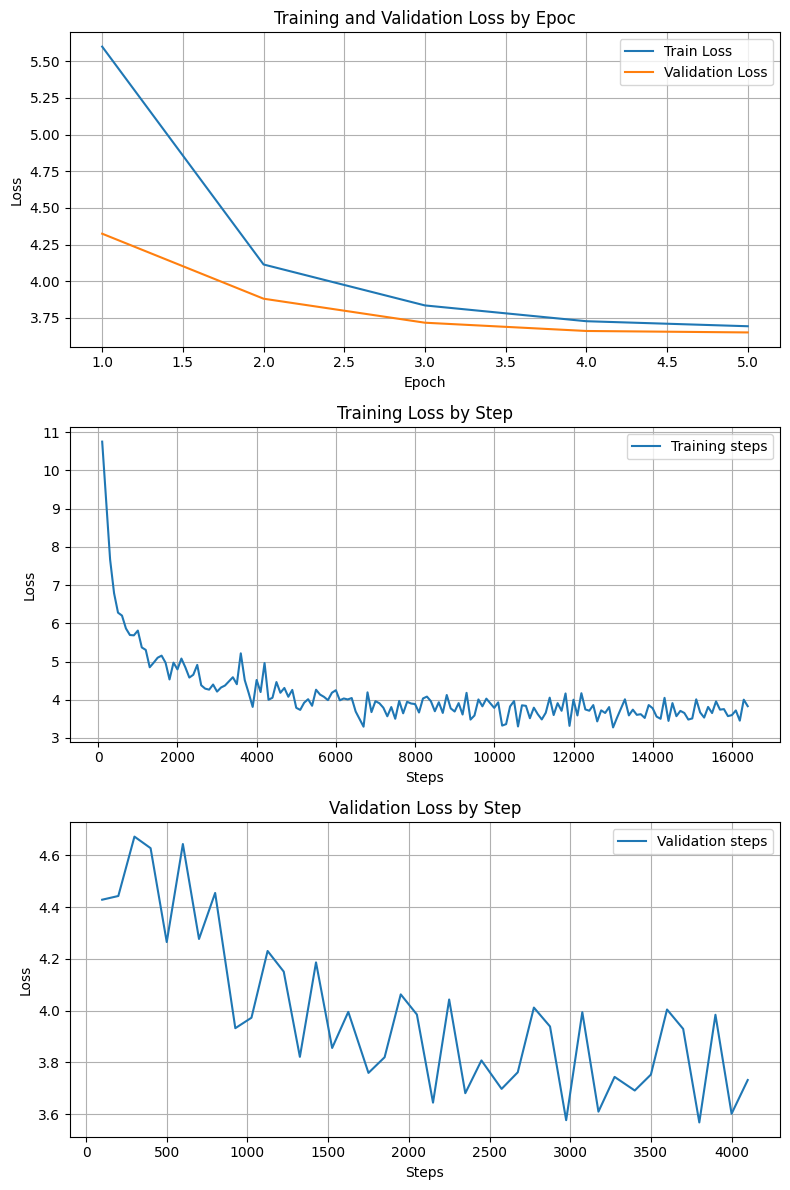

In [17]:
# TODO: Visualize the training and validation results

# Create three subplots:
fig, axes = plt.subplots(3, 1, figsize=(8, 12), tight_layout=True)
#    a. Plot epoch-level training and validation losses
axes[0].plot(range(1, len(epoch_train_losses) + 1), epoch_train_losses, label='Train Loss')
axes[0].plot(range(1, len(epoch_val_losses) + 1), epoch_val_losses, label='Validation Loss')
axes[0].set_title('Training and Validation Loss by Epoc')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()
#    b. Plot step-level training losses
axes[1].plot(all_train_step_nums, all_train_step_losses, label='Training steps')
axes[1].set_title('Training Loss by Step')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()
#    c. Plot step-level validation losses
axes[2].plot(all_val_step_nums, all_val_step_losses, label='Validation steps')
axes[2].set_title('Validation Loss by Step')
axes[2].set_xlabel('Steps')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid()

plt.show()

# Inference (15 Points)

Complete the function below to generate comments (positive or negative) 

In [ ]:
def generate_comment(model: nn.Module, tokenizer: Any, sentiment: str, max_length: int = 50, temperature: int = 1, top_k: int = 50, top_p: float = 0.9) -> str:
    # TODO: Implement text generation with sentiment control
    # 1. Create the appropriate prefix based on the sentiment parameter
    if sentiment in ('positive', 'pos', 'p', '+'):
        prefix = '<POS>'
    elif sentiment in ('negative', 'neg', 'n', '-'):
        prefix = '<NEG>'
    else:
        return None
    # 2. Generate text using the model's generate method
    
    device = next(model.parameters()).device
    input_ids = tokenizer.encode(prefix, return_tensors='pt').to(device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_length=input_ids.size(1) + max_length,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p
        )
    
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_text.replace(prefix, '', 1).strip()

Generate 10 positive and 10 negative comments and evaluate your results

In [19]:
# TODO: Demonstrate the model's sentiment-controlled text generation

model.eval()

for i in range(10):
#    a. Generate a positive comment using the generate_comment function:
    print(f"Positive comment {i + 1}:")
    print(generate_comment(model, tokenizer, sentiment="p", max_length=30, temperature=1, top_k=50, top_p=0.9))
#    b. Generate a negative comment using the generate_comment function:
    print(f"Negative comment {i + 1}:")
    print(generate_comment(model, tokenizer, sentiment="n", max_length=30, temperature=1, top_k=50, top_p=0.9))
    print("-" * 50)

Positive comment 1:
زود و پیک زود و فقط به خوشطعم و ممن ممنونم از اسنپ فود سپذ فود خیلی سریع ممنون و مح ممنون
Negative comment 1:
حجم به نسبت بود به هم با این رستوران غذا رو بیکی این غذا به اندازه که من بارو و از  عدد سفارش دادم  د مت
--------------------------------------------------
Positive comment 2:
خیلی عالی بود اما برنج خوب بود خوش بر خوب بود و طعم خیلی خوب بود ممنون از شیرینی عالی در سوپ ممنون از همه چی عالی
Negative comment 2:
مرغ سو ب بود انگ ن میش در از اسنپ فود از این رستوران غذا به صورت از یک پیک در ضمن قیمت  د و قیمت
--------------------------------------------------
Positive comment 3:
خوب بود پیک بود و پیک هم بود و از هم تشکر از شما مرسی از زمان مثل را و زود بود و ممنون از نظر سریع اس باگ
Negative comment 3:
با توجه به پخته و هم خیلی کم بود اصلا کیفیت بد و پک نبود سس پایین بود متاسفانه بد نبود اصلا از غذای برنج
--------------------------------------------------
Positive comment 4:
مثل همیشه تازه و تازه اسیر ممنونم مر تشکر از اینکه پیک هم بسیار خوب است ممن ممنون سریع مر 

## Inference Time Hyperparameters (10 Points)

Play with these parameters for the best results:
  
temperature, top_k, top_p

Briefly report what you saw and try to explain why is it happening. What is the effect of each one?

**Your Report**:  

<font color='cyan'>

## Temperature

In [20]:
temperatures = [0.6, 1.0, 1.4]
for tmp in temperatures:
    print(f"Positive comment, temperature: {tmp}")
    print(generate_comment(model, tokenizer, sentiment="p", max_length=30, temperature=tmp, top_k=50, top_p=0.9))
    print(f"Negative comment, temperature: {tmp}")
    print(generate_comment(model, tokenizer, sentiment="n", max_length=30, temperature=tmp, top_k=50, top_p=0.9))
    print("-" * 50)

Positive comment, temperature: 0.6
عالی بود ممنون ازتون هم ممنون از اسنپ فود و عالی و به موقع و عالی ممنون از اس عالی ممنونم از اس مر
Negative comment, temperature: 0.6
واقعا بد بود و خیلی خیلی بد بود هم سرد بود و اصلا سس سالاد سس خیلی خوب بود و اصلا از از پیتزا نون بود
--------------------------------------------------
Positive comment, temperature: 1.0
عالی دا دا خوش سپمنون و فقط عالی همه خیلی سریعتر بود ممنون ازشونتونون ممنونم خیلی سریع هم همه کیفیت خوبتون مر زود عالی
Negative comment, temperature: 1.0
من  لی کهنه از سفارش میدم با اینکه برای پیگیری کردن واقعا بد  دقیقه میگیرم سس هم خوب بود که به این
--------------------------------------------------
Positive comment, temperature: 1.4
فوق خوش پیک عالی اسیر مثل بهشونتون و هم عالی  گرم مر بسیار ممنون فقط تشکر خوشم برای و اینکه به موقع سپیم ممنون
Negative comment, temperature: 1.4
مرغ سزار ب اصلا سفتم بد مزه بد بود انگ یه چیز دیگه کتون موندست ف نمید که تو زمان برین تو
--------------------------------------------------


<font color='cyan'>
    
- Overall `Temperature` controls the ***softness*** of the probability distribution before sampling.

- Thus when we use low values for it, (e.g., 0.6) it sharpens the distribution, makes the model too repetitive and basically makes it safer and more deterministic (it doesn't risk that much when it's choosing its next token). It also makes the model look kinda fake, because it has less variety and most of the sentences look the same.

- On the other hand when we use higher values for it, (e.g., 1.4) it flattens the distribution, makes the model more createive (because even lower-probability tokens get a chance to be chosen) and basically makes it less safe and a bit risky. By that I mean that it may cause the model to generate gibberish and may increase incoherency.


<font color='cyan'>

### Top_K

In [21]:
top_ks = [1, 50, 200]
for tks in top_ks:
    print(f"Positive comment, top_k: {tks}")
    print(generate_comment(model, tokenizer, sentiment="p", max_length=30, temperature=1, top_k=tks, top_p=0.9))
    print(f"Negative comment, top_k: {tks}")
    print(generate_comment(model, tokenizer, sentiment="n", max_length=30, temperature=1, top_k=tks, top_p=0.9))
    print("-" * 50)

Positive comment, top_k: 1
عالی بود هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم هم
Negative comment, top_k: 1
پیتزا و سرد بود و اصلا اصلا اصلا پیتزا نبود و پیتزا هم نبود و بد بود و پیتزا هم پیتزا هم
--------------------------------------------------
Positive comment, top_k: 50
به موقع و خوش پیتزا ساندویچ خوش زود به دستمال دستم رسید با تشکر از دستم واقعا ممنون ازتونم تشکر مر
Negative comment, top_k: 50
غذا سرد بود به نسبت به هم از پیتزا کم شده بود این قیمت هم قیمت پیتزا با تشکر از پیتزا هم پیتزیش
--------------------------------------------------
Positive comment, top_k: 200
به دست هم مثل همیشه عالی و سریع و باکیف اس من از پیک فود با اینکه اینکه از بار و بسته اسنپ فسهای همینونم
Negative comment, top_k: 200
پ پرد بود بسته پیکن پیتزا و خیلی خوبه خیلی سرد و پیتز میون نپبر غذا و کیفیت طعم خمیر بود دور
--------------------------------------------------


<font color='cyan'>

- By using `Top_K` we limit the candidate pool to the ***𝑘 highest-scoring*** tokens at each step.

- Thus when we use lower values for it (e.g., 1) we basically make the model very deterministic, making it always choose the single (in this case) most probable token. It's has quite the same effects as low temperatures. They both make the model very safe and thus the model doesn't have that much of a variety and creativity. It always uses the some specific words.

- On the other hand, when we use higher values, (e.g., 200) the token pool will be so large for the model that makes the model act quite the same as randomly (because there are so many different tokens that model can choose from in each step). Again it has the same effects of high temperature values. They both make the model very creative and also prone to incoherence and gibberish generations.

<font color='cyan'>

### Top_P

In [22]:
top_ps = [0.7, 0.9, 0.99]
for tps in top_ps:
    print(f"Positive comment, top_p: {tps}")
    print(generate_comment(model, tokenizer, sentiment="p", max_length=30, temperature=1, top_k=50, top_p=tps))
    print(f"Negative comment, top_p: {tps}")
    print(generate_comment(model, tokenizer, sentiment="n", max_length=30, temperature=1, top_k=50, top_p=tps))
    print("-" * 50)

Positive comment, top_p: 0.7
خیلی خوشم خوب و با اسن ازتون هم سریع ارسال ممنون از این مر از اسنپ فود از اسنپ فود و ممن
Negative comment, top_p: 0.7
س بود اصلا کیفیت خوبی نداشت و کیفیت پایین بود اصلا را به دستم به قیمتش از بارم خیلی بدی نبود و خیلی دونه هم غذا رو
--------------------------------------------------
Positive comment, top_p: 0.9
از پیک اسل هم سریعتر از مدیریت سریع و تشکر از کیفیت پیتز سریع مبلغ را را تشکر از عالی از ایند ممنون از از
Negative comment, top_p: 0.9
کیفیت کیفیت و پن کاک بود که به این سری سفارش میدید ساندویچ بود سفتش و واقعا هم بود پیتزا رو خیلی پایین
--------------------------------------------------
Positive comment, top_p: 0.99
همه عالی بود مثل مثل همیشه عالی خیلی خوب و عالی عالی بود فقط فقط واقعا سپ موقع سریع با تشکر از از سپ به ما عالییم همه شما واقعا همه
Negative comment, top_p: 0.99
حجم غذا سرد به به دست بد رسید بدم واقعا غذا گرم پیتزا بد بود اصلا تند من پیتزا هم افتضیکن از با س
--------------------------------------------------


<font color='cyan'>

- By using `Top_P` we make the model dynamically pick the smallest set of top tokens whose cumulative probability $\geq p$.

- Thus when we use lower values for it (e.g., 0.7), the condition will be satisfied by only seeing a small number of tokens and thus makes the model choose from a small pool of tokens. We saw before that these kinds of things cause the model to be both safe and deterministic. (Besides that we should keep in mind that by using a small subset of tokens we make the model seem fake and also robotic).

- On the other hand, when we use higher values, (e.g., 0.99) the token pool will be quite large, and thus the model has more variety when generating tokens. Again we saw before how these kinds of things cause the model to be more creative and also prone to incoherence and gibberish generations. (It has the same effect as high top_k or temperature values)

<font color='cyan'>

## Conclusion

Overall we can say that all of those three parameters act kinda in a same way. When we decrease any of them, it makes the model more deterministic, safer and also makes it have less variety when it's generating new tokens. On the other hand when we increase them, they make the model more creative, more versatile and overall add a bit of randomness to model generations. Based on those things and also the analysis that we have done above, we can say that choosing these parameters would be great:

- `Temperature`: something like 1 would be great because it doesn't sharpen the distribution that much and also doesn't make it as random as when we use higher values.

- `Top_K`: values around 50 would be good for this parameter. It doesn't make the token pool that tight or that large. The model would have enough tokens to both have creativity and to be prone to incoherence.

- `Top_P`: probabilities around 0.9 would be enough for this parameter. By that we can choose the top most probable ones (again to both have creativity and to be prone to incoherence).